In [8]:
import os
import sys
import argparse
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
from mindspore import ms_function
from tqdm import tqdm
from mindspore import Tensor, save_checkpoint
sys.path.append(os.pardir)
from layers import Dense
from dataset import create_dataset
import time
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

checkpoints_path = "./output/main_ckpt"  # 结果保存路径
image_path = "./output/main_images"  # 测试结果保存路径

n_epochs = 200
batch_size = 256 
lr=0.0002   
b1=0.5
b2=0.999 
n_cpu=8
latent_dim=100
img_size=28
channels=1
n_critic=5
clip_value=0.01
sample_interval=400


In [9]:
image_path = "./output/main_images" 
# Save the generated test image.
def save_imgs(gen_imgs1, idx):
    for i3 in range(gen_imgs1.shape[0]):
        plt.subplot(5, 5, i3 + 1)
        plt.imshow(gen_imgs1[i3, 0, :, :] / 2 + 0.5, cmap="gray")
        plt.axis("off")
    plt.savefig(image_path + "/test_{}.png".format(idx))

In [ ]:

img_shape = (channels, img_size, img_size)
latent_dim = latent_dim
n_critic = n_critic

class Generator(nn.Cell):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [Dense(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.SequentialCell(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            Dense(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def construct(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

class Discriminator(nn.Cell):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.SequentialCell(
            Dense(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            Dense(512, 256),
            nn.LeakyReLU(0.2),
            Dense(256, 1),
        )

    def construct(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
generator.update_parameters_name('generator')
discriminator.update_parameters_name('discriminator')
generator.set_train()
discriminator.set_train()

# Optimizers
optimizer_G = nn.Adam(generator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)
optimizer_D = nn.Adam(discriminator.trainable_params(), learning_rate=lr, beta1=b1, beta2=b2)
optimizer_G.update_parameters_name('optim_g')
optimizer_D.update_parameters_name('optim_d')

def compute_gradient_penalty(real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = ops.StandardNormal()((real_samples.shape[0], 1, 1, 1))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    
    grad_fn = ops.grad(discriminator)
    # Get gradient w.r.t. interpolates
    (gradients,) = grad_fn(interpolates)

    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((mnp.norm(gradients, 2, axis=1) - 1) ** 2).mean()
    return gradient_penalty

def discriminator_forward(real_imgs):
    # Sample noise as generator input
    z = ops.StandardNormal()((real_imgs.shape[0], latent_dim))

    # Generate a batch of images
    fake_imgs = generator(z)

    # Real images
    real_validity = discriminator(real_imgs)
    # Fake images
    fake_validity = discriminator(fake_imgs)
    # Gradient penalty
    gradient_penalty = compute_gradient_penalty(real_imgs, fake_imgs)
    # Adversarial loss
    d_loss = -ops.reduce_mean(real_validity) + ops.reduce_mean(fake_validity) + lambda_gp * gradient_penalty
    
    return d_loss, z

def generator_forward(z):
    # Generate a batch of images
    fake_imgs = generator(z)
    # Loss measures generator's ability to fool the discriminator
    # Train on fake images
    fake_validity = discriminator(fake_imgs)
    g_loss = -ops.reduce_mean(fake_validity)

    return g_loss, fake_imgs

grad_generator_fn = ops.value_and_grad(generator_forward, None,
                                       optimizer_G.parameters,
                                       has_aux=True)
grad_discriminator_fn = ops.value_and_grad(discriminator_forward, None,
                                           optimizer_D.parameters,
                                           has_aux=True)

@ms_function
def train_step_d(imgs):
    (d_loss, z), d_grads = grad_discriminator_fn(imgs)
    optimizer_D(d_grads)
    return d_loss, z

@ms_function
def train_step_g(z):
    (g_loss, fake_imgs), g_grads = grad_generator_fn(z)
    optimizer_G(g_grads)

    return g_loss, fake_imgs

dataset = create_dataset('./dataset', 'train', img_size, batch_size, num_parallel_workers=n_cpu)
dataset_size = dataset.get_dataset_size()

# 设置参数保存路径
os.makedirs(checkpoints_path, exist_ok=True)
# 设置中间过程生成图片保存路径
os.makedirs(image_path, exist_ok=True)

batches_done = 0

# Initialize variables to keep track of the best epoch and loss
best_g_loss = float('inf')  # Replace with float('-inf') if you want to maximize a metric instead
losses_g, losses_d = [], []

for epoch in range(n_epochs):
    t = tqdm(total=dataset_size)
    t.set_description('Epoch %i' % epoch)
    for i, (imgs, _) in enumerate(dataset.create_tuple_iterator()):
        d_loss, z = train_step_d(imgs)
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            g_loss, fake_imgs = train_step_g(z)

        t.set_postfix(g_loss=g_loss, d_loss=d_loss)
        t.update(1)
        
    losses_d.append(d_loss.asnumpy())
        #if g_loss is not None:  # Only append if g_loss was updated
    losses_g.append(g_loss.asnumpy())


    save_imgs(fake_imgs[:25].asnumpy(), epoch)
    

    # Save the best model
    save_checkpoint(generator, checkpoints_path + "/generator_%d.ckpt" % (epoch))
    save_checkpoint(discriminator, checkpoints_path + "/discriminator_%d.ckpt" % (epoch))




[WARNING] ME(800:140149254988992,MainProcess):2023-08-27-10:56:27.104.831 [mindspore/common/api.py:892] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(800:140149254988992,MainProcess):2023-08-27-10:56:27.106.467 [mindspore/common/api.py:892] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(800:140149254988992,MainProcess):2023-08-27-10:56:27.108.165 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(800:140149254988992,MainProcess):2023-08-27-10:56:27.109.547 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from 

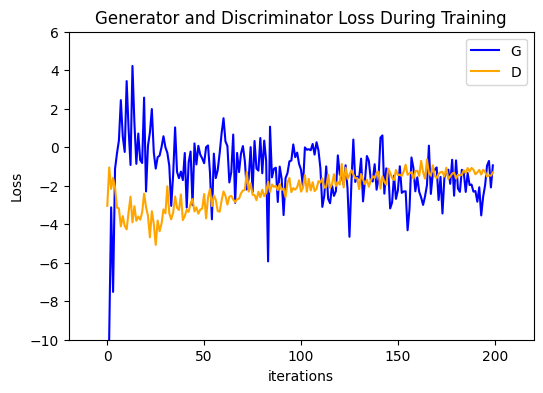

In [16]:
plt.figure(figsize=(6, 4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g, label="G", color='blue')
plt.plot(losses_d, label="D", color='orange')
plt.xlim(-20, 220)
plt.ylim(-10, 6.0)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


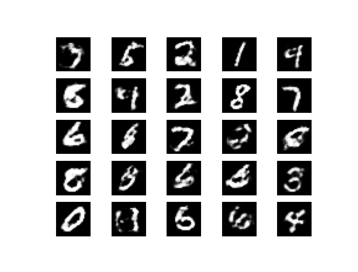

In [24]:
import cv2
import matplotlib.animation as animation
image_path = "./output/main_images" 
total_epoch = 200
# Convert the test image generated during training to a dynamic image.
image_list = []
for i in range(total_epoch):
    image_list.append(cv2.imread(image_path + "/test_{}.png".format(i), cv2.IMREAD_GRAYSCALE))
show_list = []
fig = plt.figure(dpi=70)
for epoch in range(0, len(image_list), 5):
    plt.axis("off")
    show_list.append([plt.imshow(image_list[epoch], cmap='gray')])

ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
ani.save('train_test_rlt.gif', writer='pillow', fps=1)


In [ ]:
###Model Inference

In [ ]:
###Model Inference

In [ ]:
###Model Inference

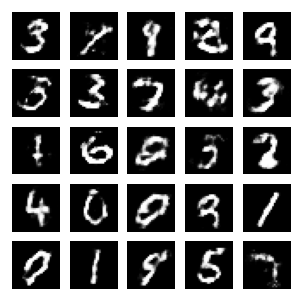

In [23]:
import mindspore as ms

test_ckpt = './output/main_ckpt/generator_199.ckpt'

parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(generator, parameter)
# Model generation result
test_data = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
test = ops.StandardNormal()((25,100))
images = generator(test).transpose(0, 2, 3, 1).asnumpy()
# Result display
fig = plt.figure(figsize=(3, 3), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")
plt.show()


In [15]:
generator.trainable_params()

[Parameter (name=optim_ggeneratormodel.0.weight, shape=(128, 100), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.0.bias, shape=(128,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.2.weight, shape=(256, 128), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.2.bias, shape=(256,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.3.gamma, shape=(256,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.3.beta, shape=(256,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.5.weight, shape=(512, 256), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.5.bias, shape=(512,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.6.gamma, shape=(512,), dtype=Float32, requires_grad=True),
 Parameter (name=optim_ggeneratormodel.6.beta, shape=(512,), dtype=Float32, requires_grad=True),
 Parameter

In [ ]:
###TASK ONE

In [ ]:
### INFERENCE OF PYTORCH MODEL

In [ ]:
##Parameter Mapping and Checkpoint Saving

In [25]:
import torch
# Print the parameter names and shapes of all parameters in the PyTorch parameter file and return the parameter dictionary.
def pytorch_params(pth_file):
    par_dict = torch.load(pth_file, map_location='cpu')
    pt_params = {}
    for name in par_dict:
        parameter = par_dict[name]
        print(name, parameter.numpy().shape)
        pt_params[name] = parameter.numpy()
    return pt_params

# Print the names and shapes of all parameters in the MindSpore cell and return the parameter dictionary.
def mindspore_params(network):
    ms_params = {}
    for param in network.get_parameters():
        name = param.name
        value = param.data.asnumpy()
        print(name, value.shape)
        ms_params[name] = value
    return ms_params


In [26]:

pth_path = "./models/ckpt/generator_199.pth"
pt_param = pytorch_params(pth_path)
print("="*20)
ms_param = mindspore_params(generator)


model.0.weight (128, 100)
model.0.bias (128,)
model.2.weight (256, 128)
model.2.bias (256,)
model.3.weight (256,)
model.3.bias (256,)
model.3.running_mean (256,)
model.3.running_var (256,)
model.3.num_batches_tracked ()
model.5.weight (512, 256)
model.5.bias (512,)
model.6.weight (512,)
model.6.bias (512,)
model.6.running_mean (512,)
model.6.running_var (512,)
model.6.num_batches_tracked ()
model.8.weight (1024, 512)
model.8.bias (1024,)
model.9.weight (1024,)
model.9.bias (1024,)
model.9.running_mean (1024,)
model.9.running_var (1024,)
model.9.num_batches_tracked ()
model.11.weight (784, 1024)
model.11.bias (784,)
optim_ggeneratormodel.0.weight (128, 100)
optim_ggeneratormodel.0.bias (128,)
optim_ggeneratormodel.2.weight (256, 128)
optim_ggeneratormodel.2.bias (256,)
generatormodel.3.moving_mean (256,)
generatormodel.3.moving_variance (256,)
optim_ggeneratormodel.3.gamma (256,)
optim_ggeneratormodel.3.beta (256,)
optim_ggeneratormodel.5.weight (512, 256)
optim_ggeneratormodel.5.bias (

In [ ]:
param = {
    'optim_ggeneratormodel.0.weight' : 'model.0.weight',
    'optim_ggeneratormodel.0.bias' : 'model.0.bias',

    'optim_ggeneratormodel.2.weight' : 'model.2.weight',
    'optim_ggeneratormodel.2.bias' : 'model.2.bias',

    'generatormodel.3.moving_mean' : 'model.3.running_mean',
    'generatormodel.3.moving_variance' : 'model.3.running_var',

    'optim_ggeneratormodel.3.gamma' : 'model.3.weight',
    'optim_ggeneratormodel.3.beta' : 'model.3.bias',

    'optim_ggeneratormodel.5.weight' : 'model.5.weight',
    'optim_ggeneratormodel.5.bias' : 'model.5.bias',

    'generatormodel.6.moving_mean' : 'model.6.running_mean',
    'generatormodel.6.moving_variance' : 'model.6.running_var',
    'optim_ggeneratormodel.6.gamma' : 'model.6.weight',
    'optim_ggeneratormodel.6.beta' : 'model.6.bias',

    'optim_ggeneratormodel.8.weight' : 'model.8.weight',
    'optim_ggeneratormodel.8.bias' : 'model.8.bias',

    'generatormodel.9.moving_mean' : 'model.9.running_mean',
    'generatormodel.9.moving_variance' : 'model.9.running_var',
    'optim_ggeneratormodel.9.gamma' : 'model.9.weight',
    'optim_ggeneratormodel.9.beta' : 'model.9.bias',

    'optim_ggeneratormodel.11.weight': 'model.11.weight',
    'optim_ggeneratormodel.11.bias' : 'model.11.bias',
}

In [ ]:
import mindspore as ms

def param_convert(ms_params, pt_params, ckpt_path):
    # Parameter name mapping dictionary
    new_params_list = []
    for ms_param in ms_params.keys():
  
            # If the corresponding parameter is found and the shape is the same, add the parameter to the parameter list.
            if param[ms_param] in pt_params and pt_params[param[ms_param]].shape == ms_params[ms_param].shape:
                ms_value = pt_params[param[ms_param]]
                new_params_list.append({"name": ms_param, "data": ms.Tensor(ms_value)})
            else:
                print(ms_param, "not match in pt_params")
    ms.save_checkpoint(new_params_list, ckpt_path)

ckpt_path = "py_model.ckpt"
param_convert(ms_param, pt_param, ckpt_path)


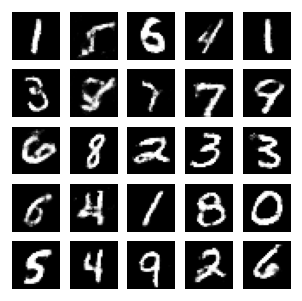

In [12]:

test_ckpt = 'py_model.ckpt'

parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(generator, parameter)
# Model generation result
test_data = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
test = ops.StandardNormal()((25,100))
images = generator(test).transpose(0, 2, 3, 1).asnumpy()
# Result display
fig = plt.figure(figsize=(3, 3), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")
plt.show()


In [ ]:
###END

In [ ]:
###END

In [ ]:
###END

In [ ]:
###END

In [ ]:
###END